### Rat Spinal Cord: Simulated Ideal Coil.
2/6/2023
Benjamin M Hardy


In [13]:
# imports
import coil
import matplotlib.pyplot as plt
import numpy as np
from math import acos, ceil, cos, exp, floor, log10, pi, sin, sqrt
from scipy.optimize import fsolve

In [9]:
# coilRatio = lcoil/dcoil
# fillRatio = lsample/dcoil

class Mag:
    def __init__(self, tr, t1, angle):
        self.tr = tr
        self.t1 = t1
        self.angle = angle
        self.m0 = 1

    def Mz(self):
        return self.m0*((1-exp(-self.tr/self.t1))/(1-cos(self.angle)*exp(-self.tr/self.t1)))
    
    def Mxy(self):
        return self.Mz()*sin(self.angle)
    
def maxMagdev(tr,t1,angle,coilR,fillR):
    aOff = angle*(1-maxRFdev(coilR,fillR))
    mOff = Mag(tr,t1,aOff)
    m = Mag(tr,t1,angle)
    return (m.Mxy() - mOff.Mxy())/m.Mxy()

def maxRFdev(coilR, fillR):
    return (1 - .5*sqrt(1+(1/coilR)**2)*((coilR + fillR)/sqrt(1+(coilR + fillR)**2)+(coilR - fillR)/sqrt(1+(coilR - fillR)**2)))

In [27]:
# constants:
tc = 289
ts = 289
sigma = 1.5
alpha = 5.4/1000 # 5.4 mm
beta = 6.3/1000 # 1 mm section
rho = 1.72e-8
f = 650e6
dcoil = 6.3/1000
# optimize coil length
#roughly lcoil = 1.8* diameter of coil, l sample is same as diameter of coil
print(dcoil*1000,'mm (diameter of coil)')
lcoil = 1.8*dcoil
print(lcoil*1000,'mm (length of coil)')
# optimize coil number of turns
# 4 turns
print(4,'turns')
# optimize diameter of wire
print(1,'mm (wire diameter)')



6.3 mm (diameter of coil)
11.340000000000002 mm (length of coil)
4 turns
1 mm (wire diameter)


c:\Users\benja\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The solution is coilR =  [-6.45277537e-05]
at which the value of the expression is  [0.07588868]


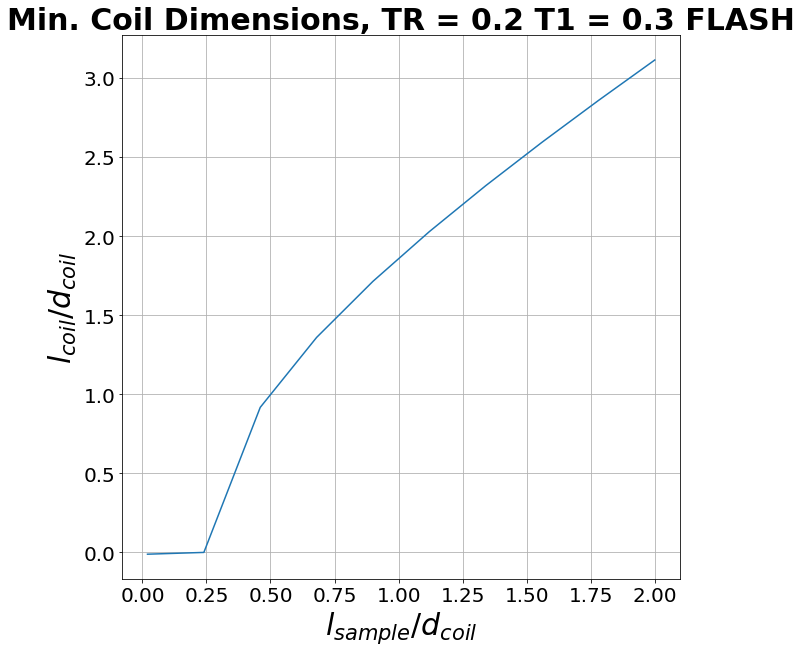

In [19]:
################### Plotting custom minimal Solenoid Coil Sizes
# recreate figure 9
# Vary fillR
lcoil = 8/1000
lsample = .1*lcoil
fillR = lsample/dcoil

maxSigdev = .1
tr = .200
t1 = .300
ernstAngle = acos(exp(-tr/t1))

# defs vectorized?
npvMaxRfDev = np.vectorize(maxRFdev)
npvMaxMagDev = np.vectorize(maxMagdev)

# equation 10 in part I
# maxSigdev = maxRFdev() + maxMagdev() - (maxRFdev()*maxMagdev())
func = lambda coilR : maxSigdev - npvMaxRfDev(coilR,fillR) - npvMaxMagDev(tr,t1,ernstAngle,coilR,fillR) + npvMaxRfDev(coilR,fillR)*npvMaxMagDev(tr,t1,ernstAngle,coilR,fillR)

# plot it
coilR = np.linspace(.01,5,100)

# plt.plot(coilR,func(coilR))
# plt.xlabel("coilR")
# plt.ylabel("solution at 0")
# plt.grid()
# plt.show()

initGuess = 1
coilR_solution = fsolve(func,initGuess)
    

print("The solution is coilR = ", coilR_solution)
print("at which the value of the expression is ", func(coilR_solution))

# loop it
fillR_v = np.linspace(0.02,2,10)
coilR_sols = []
for x in fillR_v:
    fillR = x
    func = lambda coilR : maxSigdev - npvMaxRfDev(coilR,fillR) - npvMaxMagDev(tr,t1,ernstAngle,coilR,fillR) + npvMaxRfDev(coilR,fillR)*npvMaxMagDev(tr,t1,ernstAngle,coilR,fillR)
    initGuess = x
    coilR_solution = fsolve(func,initGuess)
    #print("The solution is coilR = ", coilR_solution)
    #print("at which the value of the expression is ", func(coilR_solution))
    coilR_sols.append(coilR_solution)

plt.figure(figsize=(10,10))
plt.plot(fillR_v,coilR_sols)
plt.xlabel(r'$l_{sample}/d_{coil}$',fontsize=30, fontweight='bold')
plt.ylabel(r'$l_{coil}/d_{coil}$',fontsize=30, fontweight='bold')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title(('Min. Coil Dimensions, TR = ' + str(tr) + ' T1 = '+ str(t1) + ' FLASH'),fontsize=30, fontweight='bold')
plt.grid()
plt.show()

# roughly lcoil = 1.8* diameter of coil, l sample is same as diameter of coil

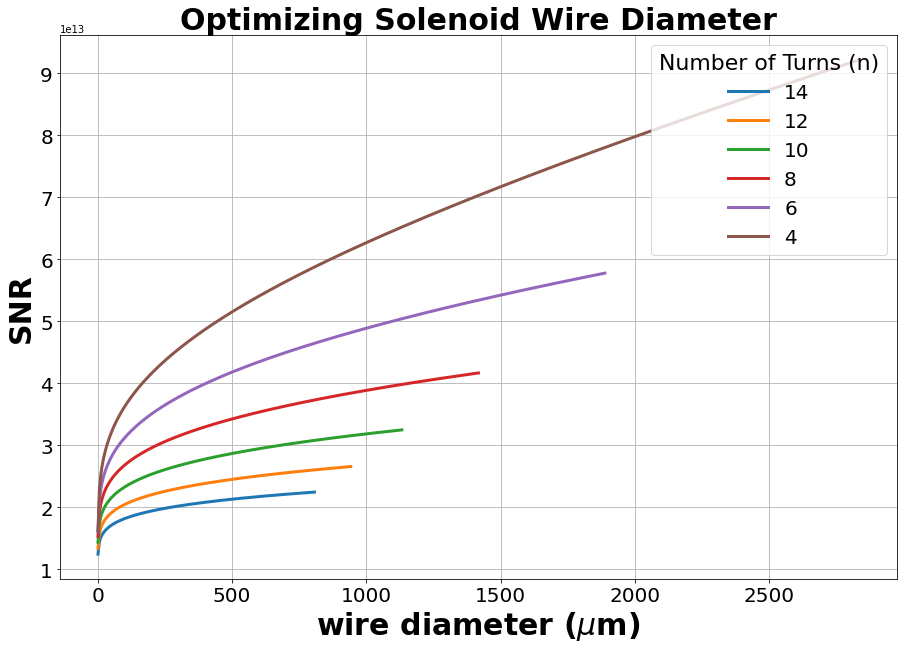

In [25]:
# optimize number of turns and the wire diameter

def runWireDiameterLoop(n,dcoil,lcoil):
    ########## Plotting equation 10 in Part II
    # vary dwire - fix coil diameter, length, different n values do it in meters!
    dwire_v = np.linspace(0.000001,.005,1000)
    sig_v = np.array([]) 
    endi = 1000
    i = 0
    for dw in dwire_v:
        # (self, n, dcoil, lcoil, dwire, f, rho, alpha, beta, sigma,tc,ts)
        c = coil.Coil(n,dcoil,lcoil,dw,f,rho,alpha,beta,sigma,tc,ts)
        # stop plotting d/s > 1
        if (c.dwire/c.s > 1):
            endi = i
            break
        sig_v = np.append(sig_v,c.getSNR())
        i = i+1

    return dwire_v[0:endi]*1e6, sig_v

plt.figure(figsize=(15,10))
dw, sig = runWireDiameterLoop(14,dcoil,lcoil)
plt.plot(dw,sig,linewidth=3)
dw, sig = runWireDiameterLoop(12,dcoil,lcoil)
plt.plot(dw,sig,linewidth=3)
dw, sig = runWireDiameterLoop(10,dcoil,lcoil)
plt.plot(dw,sig,linewidth=3)
dw, sig = runWireDiameterLoop(8,dcoil,lcoil)
plt.plot(dw,sig,linewidth=3)
dw, sig = runWireDiameterLoop(6,dcoil,lcoil)
plt.plot(dw,sig,linewidth=3)
dw, sig = runWireDiameterLoop(4,dcoil,lcoil)
plt.plot(dw,sig,linewidth=3)
# dw, sig = runWireDiameterLoop(3,dcoil,lcoil)
# plt.plot(dw,sig)

plt.xlabel('wire diameter ($\mu$m)',fontsize=30, fontweight='bold')
plt.ylabel('SNR',fontsize=30, fontweight='bold')
#plt.ylabel('SNR',r'$\mathrm{(\frac{\omega_{0}^2 B_{xy}}{\sqrt{R_{nmr}}})}$', fontsize=30, fontweight='bold')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Optimizing Solenoid Wire Diameter',fontsize=30, fontweight='bold')
plt.legend(("14","12","10","8","6","4"),loc='upper right', title='Number of Turns (n)',fontsize=20,title_fontsize=22)
#plt.legend(("30","20","15","12","8","4","8","4","3"),loc='upper right', title='Number of Turns (n)',fontsize=20)

plt.grid()
plt.show()